In [1]:
import os
from googleapiclient.discovery import build as build_api_client

In [2]:
assert 'YOUTUBE_API_KEY' in os.environ
yt = build_api_client('youtube', 'v3', developerKey=os.environ['YOUTUBE_API_KEY'])

In [3]:
def load_categories_from_api(video_ids):
    request = yt.videos().list(
        part='snippet',
        id=','.join(video_ids)
    )
    response = request.execute()
    return {item['id']: item['snippet']['categoryId'] for item in response['items']}

In [51]:
import numpy as np
import pandas as pd
import tqdm.notebook
from loaders import load_semi_supervised, load_categories

tqdm.notebook.tqdm()
df = load_semi_supervised()
categories = load_categories()
api_categories = pd.read_csv('../youtube_data/api_categories.csv').set_index('video_id')
df = df.join(api_categories, on='video_id')
df

,video_id,predicted_category_id,dataset_category_id,category_id
0,Jw1Y-zhQURU,26,NaN,NaN
1,3s1rvMFUweQ,24,NaN,NaN
2,n1WpP7iowLc,10,NaN,10.0
3,PUTEiSjKwJU,22,NaN,17.0
4,rHwDegptbI4,24,NaN,NaN
...,...,...,...,...
8602,Gi56dSh8Fq8,26,NaN,22.0
8603,dS5Thrl-4Kc,26,NaN,26.0
8604,JGm9Y_hFqNk,20,NaN,17.0
8605,mpnshdmtE2Y,26,NaN,26.0


In [19]:
if False:
    unknown_ids = df[df['dataset_category_id'].isnull()]['video_id']

    print(len(unknown_ids))

    def chunker(seq, size):
        return (seq[pos:pos + size] for pos in range(0, len(seq), size))

    categories_dict = {}

    videos_per_query = 20
    for chunk in tqdm.tqdm(chunker(unknown_ids, videos_per_query), total=len(unknown_ids)/videos_per_query):
        video_ids = list(chunk)
        response = load_categories_from_api(video_ids)
        categories_dict.update(response)
        for vid, category in response.items():
            df.loc[df['video_id'] == vid, 'api_category_id'] = int(category)

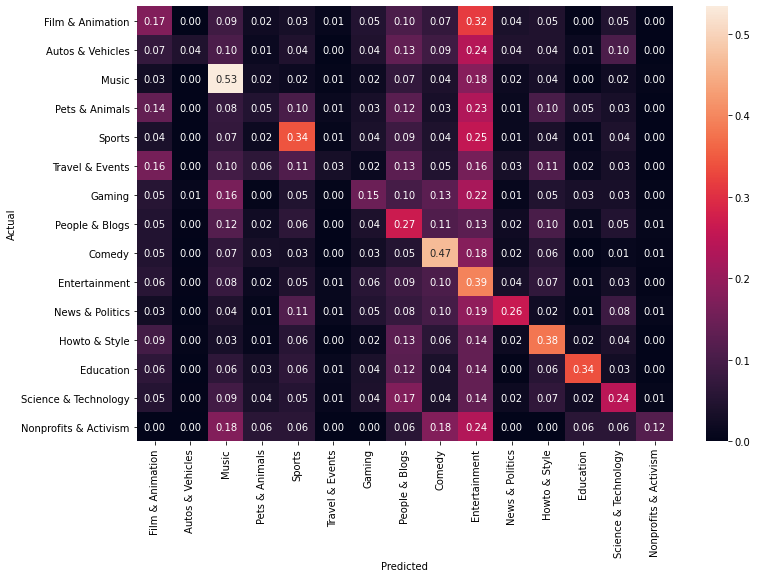

In [66]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

known = df[~df['category_id'].isna()]

ctg_ids = [int(ctg) for ctg in categories.keys() if (known['category_id'] == int(ctg)).any()]
labels = [categories[str(ctg)] for ctg in ctg_ids]

conf = confusion_matrix(known['category_id'], known['predicted_category_id'], normalize='true', labels=ctg_ids)
plt.figure(figsize=(12, 8))
sns.heatmap(conf, annot=True, xticklabels=labels, yticklabels=labels, fmt='.2f')
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.show()


In [69]:
from sklearn.metrics import classification_report

print(classification_report(known['category_id'], known['predicted_category_id'], labels=ctg_ids, target_names=labels))

                       precision    recall  f1-score   support

     Film & Animation       0.16      0.17      0.16       421
     Autos & Vehicles       0.15      0.04      0.07        67
                Music       0.57      0.53      0.55      1310
       Pets & Animals       0.04      0.05      0.05       146
               Sports       0.35      0.34      0.35       585
      Travel & Events       0.04      0.03      0.03        63
               Gaming       0.11      0.15      0.12       238
       People & Blogs       0.20      0.27      0.23       623
               Comedy       0.33      0.47      0.38       581
        Entertainment       0.42      0.39      0.41      2008
      News & Politics       0.46      0.26      0.33       559
        Howto & Style       0.39      0.38      0.38       691
            Education       0.51      0.34      0.41       262
 Science & Technology       0.26      0.24      0.25       389
Nonprofits & Activism       0.06      0.12      0.08  